# Algorithm Illustrations & Visualizations

This notebook contains visualizations comparing **Standard Isolation Forest** and **K-Means Isolation Forest**:

1. **Elbow Rule Demonstration**: K-Means optimal cluster selection
2. **Dataset Visualizations**: 9-rectangles, moons, circles datasets
3. **Anomaly Detection Performance**: True vs Predicted labels
4. **Confusion Matrices & PR Curves**: Quantitative evaluation
5. **Anomaly Score Heatmaps**: Visual comparison of scoring functions
6. **Rank Difference Analysis**: Algorithm agreement analysis

All visualizations are publication-quality with improved styling from the original presentation.

## Setup and Imports

In [20]:
import os
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent))

from matplotlib.patches import Rectangle

from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score,
    balanced_accuracy_score,
    f1_score
)
from sklearn.cluster import KMeans

from src.isolation.forest import IsolationForest
from src.kmeans_isolation.forest import KMeansIsolationForest

sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

os.makedirs('../results/illustrations', exist_ok=True)
print("All imports successful \u2705")

All imports successful ✅


## Dataset Generation Functions

In [21]:
def generate_9_rectangles(
    n_normal=900, 
    n_anomalies=100, 
    seed=42
):
    """Generate 9 rectangles dataset (3x3 grid) with anomalies."""
    np.random.seed(seed)
    
    rectangles = []
    for i in range(3):
        for j in range(3):
            Xs_rectangle = np.random.uniform(
                low=[i * 3, j * 3],
                high=[i * 3 + 2, j * 3 + 2],
                size=(n_normal // 9, 2)
            )
            rectangles.append(Xs_rectangle)
    
    Xs_normal = np.vstack(rectangles)
    
    # Generate anomalies uniformly across the entire space
    Xs_anomalies = np.random.uniform(
        low=[0, 0],
        high=[9, 9],
        size=(n_anomalies, 2)
    )
    
    X = np.vstack([Xs_normal, Xs_anomalies])
    y = np.array([0] * n_normal + [1] * n_anomalies)
    return X, y


def generate_moons(
    n_normal=900, 
    n_anomalies=100, 
    seed=42
):
    """Generate moons dataset with anomalies."""
    np.random.seed(seed)
    
    Xs_normal, _ = make_moons(n_samples=n_normal, noise=0.05, random_state=seed)
    Ys_normal = np.zeros(n_normal, dtype=int)
    
    Xs_anomalies = np.random.uniform(
        low=[-3.0, -3.0],
        high=[3.0, 3.0],
        size=(n_anomalies, 2)
    )
    Ys_anomalies = np.ones(n_anomalies, dtype=int)
    
    X = np.vstack([Xs_normal, Xs_anomalies])
    y = np.hstack([Ys_normal, Ys_anomalies])
    return X, y


def generate_circles(
    n_normal=900, 
    n_anomalies=100, 
    seed=42
):
    """Generate circles dataset with anomalies."""
    np.random.seed(seed)
    
    Xs_normal, _ = make_circles(n_samples=n_normal, noise=0.05, random_state=seed, factor=0.5)
    Ys_normal = np.zeros(n_normal, dtype=int)
    
    Xs_anomalies = np.random.uniform(
        low=[-2.0, -2.0],
        high=[2.0, 2.0],
        size=(n_anomalies, 2)
    )
    Ys_anomalies = np.ones(n_anomalies, dtype=int)
    
    X = np.vstack([Xs_normal, Xs_anomalies])
    y = np.hstack([Ys_normal, Ys_anomalies])
    return X, y


print("Dataset generation functions defined \u2705")

Dataset generation functions defined ✅


## Helper Functions

In [22]:
def find_optimal_kmeans(Xs):
    initial_Ks = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 51]
    Ks = [k for k in initial_Ks if k <= Xs.shape[0]]
    
    if len(Ks) == 0:
        return 2, None
    
    inertias = []
    kmeans_list = []
    for k in Ks:
        kmeans = KMeans(n_clusters=k, random_state=23, n_init=10)
        kmeans.fit(Xs)
        inertias.append(kmeans.inertia_)
        kmeans_list.append(kmeans)
    
    # Calculate distances from baseline (line connecting first and last points)
    baseline_slope = (inertias[-1] - inertias[0]) / (Ks[-1] - Ks[0])
    baseline_intercept = inertias[0] - baseline_slope * Ks[0]
    
    distances = []
    for i, k in enumerate(Ks):
        baseline_y = baseline_slope * k + baseline_intercept
        distance = abs(inertias[i] - baseline_y)
        distances.append(distance)
    
    optimal_idx = np.argmax(distances)
    optimal_k = Ks[optimal_idx]
    
    return optimal_k, kmeans_list[optimal_idx]

print("Helper functions defined \u2705")

Helper functions defined ✅


---
# Section 1: Elbow Rule Demonstration

Visualizes the elbow method used by K-Means Isolation Forest to determine optimal cluster count.

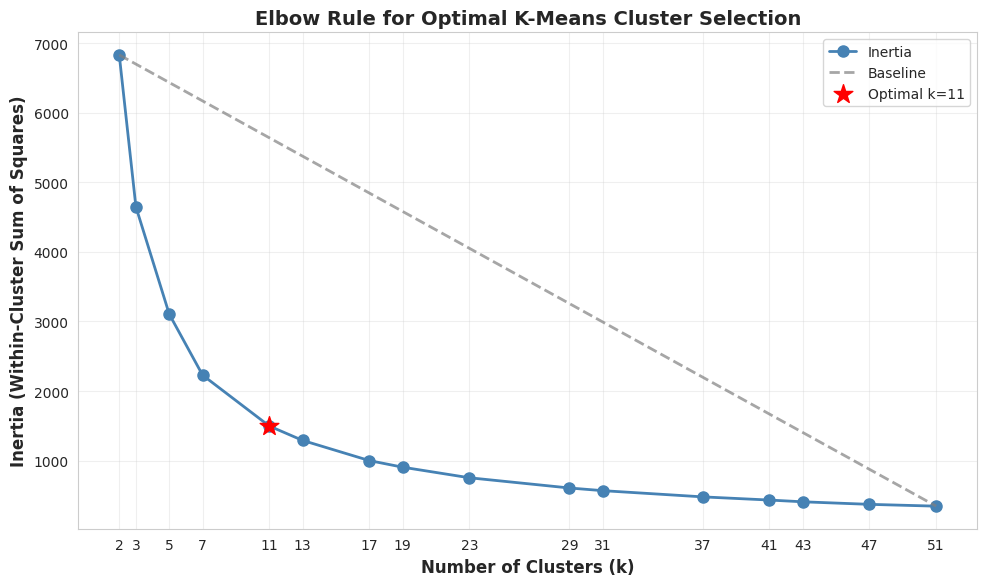

Elbow rule visualization saved ✅
  Optimal k: 11


In [23]:
# Generate sample data
np.random.seed(42)
X_sample = np.random.randn(5000, 2)

Ks = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 51]
inertias = []

for k in Ks:
    kmeans = KMeans(n_clusters=k, random_state=23, n_init=10)
    kmeans.fit(X_sample)
    inertias.append(kmeans.inertia_)

optimal_k, _ = find_optimal_kmeans(X_sample)

fig, ax = plt.subplots(figsize=(10, 6))

# Plot inertia curve
ax.plot(Ks, inertias, 'o-', linewidth=2, markersize=8, color='steelblue', label='Inertia')

# Plot baseline (first to last point)
ax.plot([Ks[0], Ks[-1]], [inertias[0], inertias[-1]], '--', 
        linewidth=2, color='gray', alpha=0.7, label='Baseline')

# Highlight optimal k
optimal_idx = Ks.index(optimal_k)
ax.scatter([optimal_k], [inertias[optimal_idx]], s=200, color='red', 
           zorder=5, marker='*', label=f'Optimal k={optimal_k}')

ax.set_xlabel('Number of Clusters (k)', fontweight='bold')
ax.set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontweight='bold')
ax.set_title('Elbow Rule for Optimal K-Means Cluster Selection', fontweight='bold', fontsize=14)

ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

ax.set_xticks(Ks)

plt.tight_layout()
plt.savefig('../results/illustrations/elbow_rule.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Elbow rule visualization saved \u2705")
print(f"  Optimal k: {optimal_k}")

---
# Section 2: 9-Rectangle Dataset Visualization

The classic benchmark dataset from the paper comparing both algorithms.

In [24]:
X_rect, y_rect = generate_9_rectangles(n_normal=900, n_anomalies=100, seed=42)
X_train_rect, X_test_rect, y_train_rect, y_test_rect = train_test_split(
    X_rect, y_rect, test_size=0.25, random_state=42
)

print(f"Dataset shape: {X_rect.shape}")
print(f"Normal points: {np.sum(y_rect == 0)}")
print(f"Anomalies: {np.sum(y_rect == 1)}")

Dataset shape: (1000, 2)
Normal points: 900
Anomalies: 100


### Visualize Dataset with Rectangle Boundaries

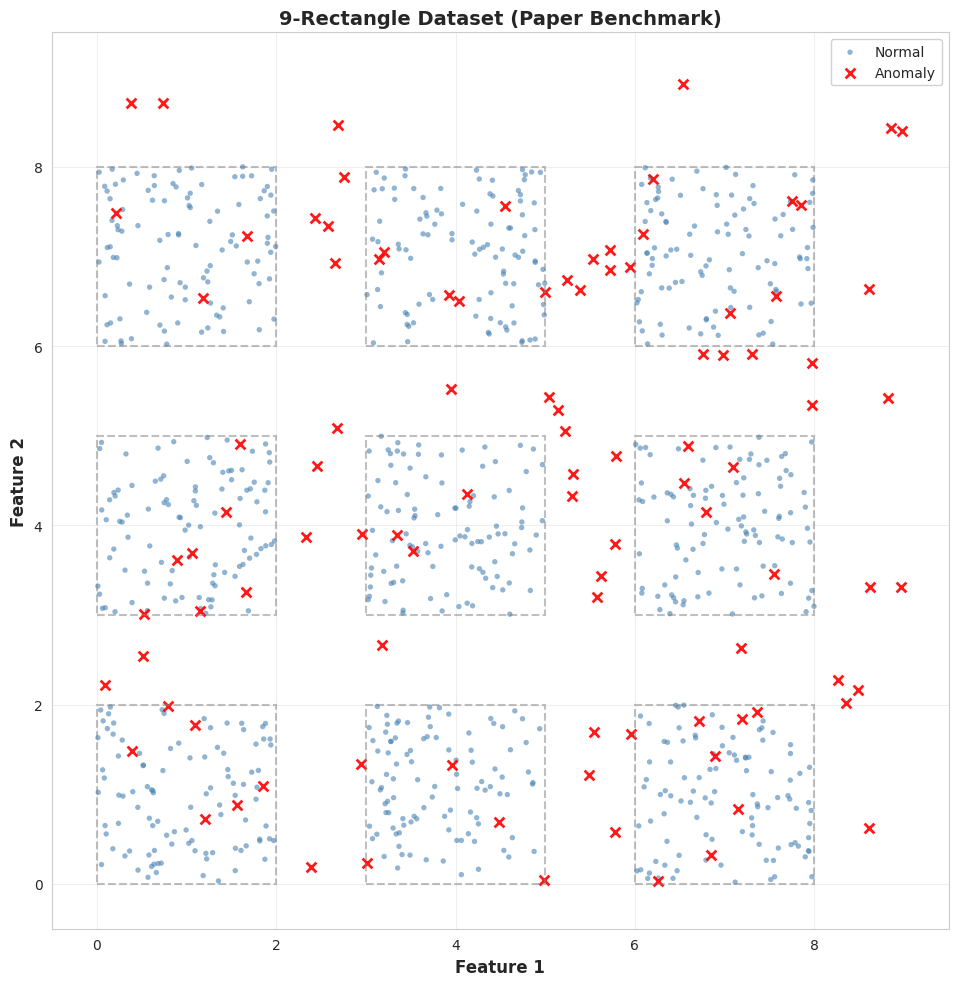

9-rectangle dataset visualization saved ✅


In [25]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot normal points
ax.scatter(X_rect[y_rect == 0, 0], X_rect[y_rect == 0, 1], 
           c='steelblue', s=15, alpha=0.6, label='Normal', edgecolors='none')

# Plot anomalies
ax.scatter(X_rect[y_rect == 1, 0], X_rect[y_rect == 1, 1], 
           c='red', s=50, alpha=0.9, marker='x', linewidths=2, label='Anomaly')

for i in range(3):
    for j in range(3):
        rect = Rectangle((i*3, j*3), 2, 2, 
                        linewidth=1.5, edgecolor='gray', 
                        facecolor='none', linestyle='--', alpha=0.5)

        ax.add_patch(rect)

ax.set_xlabel('Feature 1', fontweight='bold')
ax.set_ylabel('Feature 2', fontweight='bold')
ax.set_title('9-Rectangle Dataset (Paper Benchmark)', fontweight='bold', fontsize=14)

ax.legend(loc='upper right', framealpha=0.9)

ax.set_xlim(-0.5, 9.5)
ax.set_ylim(-0.5, 9.5)
ax.set_aspect('equal')

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/illustrations/9_rectangles_dataset.png', dpi=300, bbox_inches='tight')
plt.show()

print("9-rectangle dataset visualization saved \u2705")

### Train Both Models on 9-Rectangle Dataset

In [26]:
CONTAMINATION = 0.1
SUBSAMPLE_SIZE = 256

# Train Standard Isolation Forest
print("Training Standard Isolation Forest")
if_standard = IsolationForest(ensemble_size=100, random_state=42, n_jobs=-1)
if_standard.fit(X_train_rect, subsample_size=SUBSAMPLE_SIZE, contamination=CONTAMINATION)

pred_train_std = if_standard.predict(X_train_rect)
pred_test_std = if_standard.predict(X_test_rect)
scores_train_std = if_standard.scores(X_train_rect)
scores_test_std = if_standard.scores(X_test_rect)

# Train K-Means Isolation Forest
print("\nTraining K-Means Isolation Forest")
if_kmeans = KMeansIsolationForest(ensemble_size=100, random_state=42, n_jobs=-1)
if_kmeans.fit(X_train_rect, subsample_size=SUBSAMPLE_SIZE, contamination=CONTAMINATION)

pred_train_km = if_kmeans.predict(X_train_rect)
pred_test_km = if_kmeans.predict(X_test_rect)
scores_train_km = if_kmeans.scores(X_train_rect)
scores_test_km = if_kmeans.scores(X_test_rect)

Training Standard Isolation Forest

Training K-Means Isolation Forest


### Compare Predictions: True vs Predicted Labels

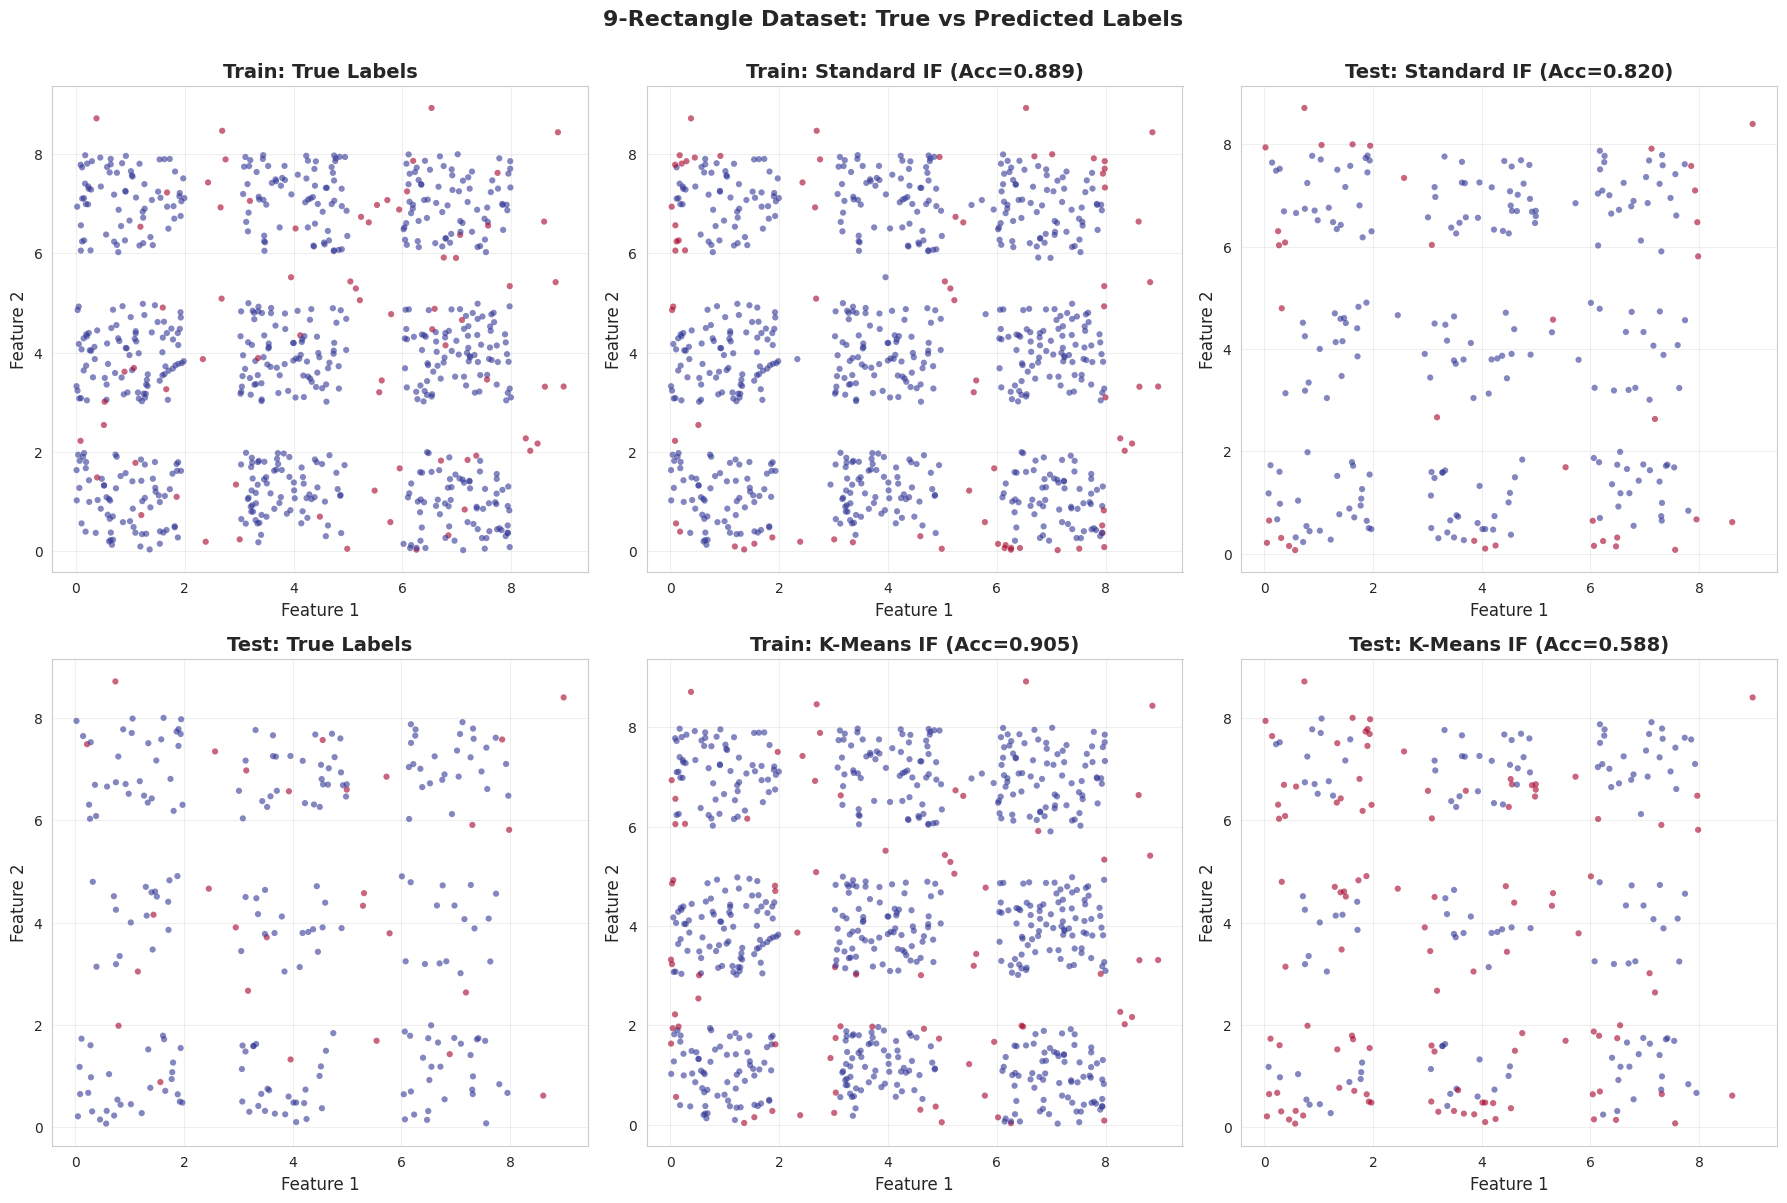

Predictions visualization saved ✅


In [27]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Standard Isolation Forest
# True labels (train)
axes[0, 0].scatter(X_train_rect[:, 0], X_train_rect[:, 1], c=y_train_rect, 
                   cmap='RdYlBu_r', s=20, alpha=0.6, edgecolors='none')
axes[0, 0].set_title('Train: True Labels', fontweight='bold')
axes[0, 0].set_xlabel('Feature 1')
axes[0, 0].set_ylabel('Feature 2')
axes[0, 0].grid(True, alpha=0.3)

# Predicted labels (train) - Standard IF
axes[0, 1].scatter(X_train_rect[:, 0], X_train_rect[:, 1], c=pred_train_std, 
                   cmap='RdYlBu_r', s=20, alpha=0.6, edgecolors='none')
acc_train_std = np.mean(pred_train_std == y_train_rect)
axes[0, 1].set_title(f'Train: Standard IF (Acc={acc_train_std:.3f})', fontweight='bold')
axes[0, 1].set_xlabel('Feature 1')
axes[0, 1].set_ylabel('Feature 2')
axes[0, 1].grid(True, alpha=0.3)

# Predicted labels (test) - Standard IF
axes[0, 2].scatter(X_test_rect[:, 0], X_test_rect[:, 1], c=pred_test_std, 
                   cmap='RdYlBu_r', s=20, alpha=0.6, edgecolors='none')
acc_test_std = np.mean(pred_test_std == y_test_rect)
axes[0, 2].set_title(f'Test: Standard IF (Acc={acc_test_std:.3f})', fontweight='bold')
axes[0, 2].set_xlabel('Feature 1')
axes[0, 2].set_ylabel('Feature 2')
axes[0, 2].grid(True, alpha=0.3)

# Row 2: K-Means Isolation Forest
# True labels (test)
axes[1, 0].scatter(X_test_rect[:, 0], X_test_rect[:, 1], c=y_test_rect, 
                   cmap='RdYlBu_r', s=20, alpha=0.6, edgecolors='none')
axes[1, 0].set_title('Test: True Labels', fontweight='bold')
axes[1, 0].set_xlabel('Feature 1')
axes[1, 0].set_ylabel('Feature 2')
axes[1, 0].grid(True, alpha=0.3)

# Predicted labels (train) - K-Means IF
axes[1, 1].scatter(X_train_rect[:, 0], X_train_rect[:, 1], c=pred_train_km, 
                   cmap='RdYlBu_r', s=20, alpha=0.6, edgecolors='none')
acc_train_km = np.mean(pred_train_km == y_train_rect)
axes[1, 1].set_title(f'Train: K-Means IF (Acc={acc_train_km:.3f})', fontweight='bold')
axes[1, 1].set_xlabel('Feature 1')
axes[1, 1].set_ylabel('Feature 2')
axes[1, 1].grid(True, alpha=0.3)

# Predicted labels (test) - K-Means IF
axes[1, 2].scatter(X_test_rect[:, 0], X_test_rect[:, 1], c=pred_test_km, 
                   cmap='RdYlBu_r', s=20, alpha=0.6, edgecolors='none')
acc_test_km = np.mean(pred_test_km == y_test_rect)
axes[1, 2].set_title(f'Test: K-Means IF (Acc={acc_test_km:.3f})', fontweight='bold')
axes[1, 2].set_xlabel('Feature 1')
axes[1, 2].set_ylabel('Feature 2')
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('9-Rectangle Dataset: True vs Predicted Labels', fontweight='bold', fontsize=16, y=1.00)
plt.tight_layout()

plt.savefig('../results/illustrations/9_rectangles_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Predictions visualization saved \u2705")

### Performance Metrics: Confusion Matrices & Precision-Recall Curves

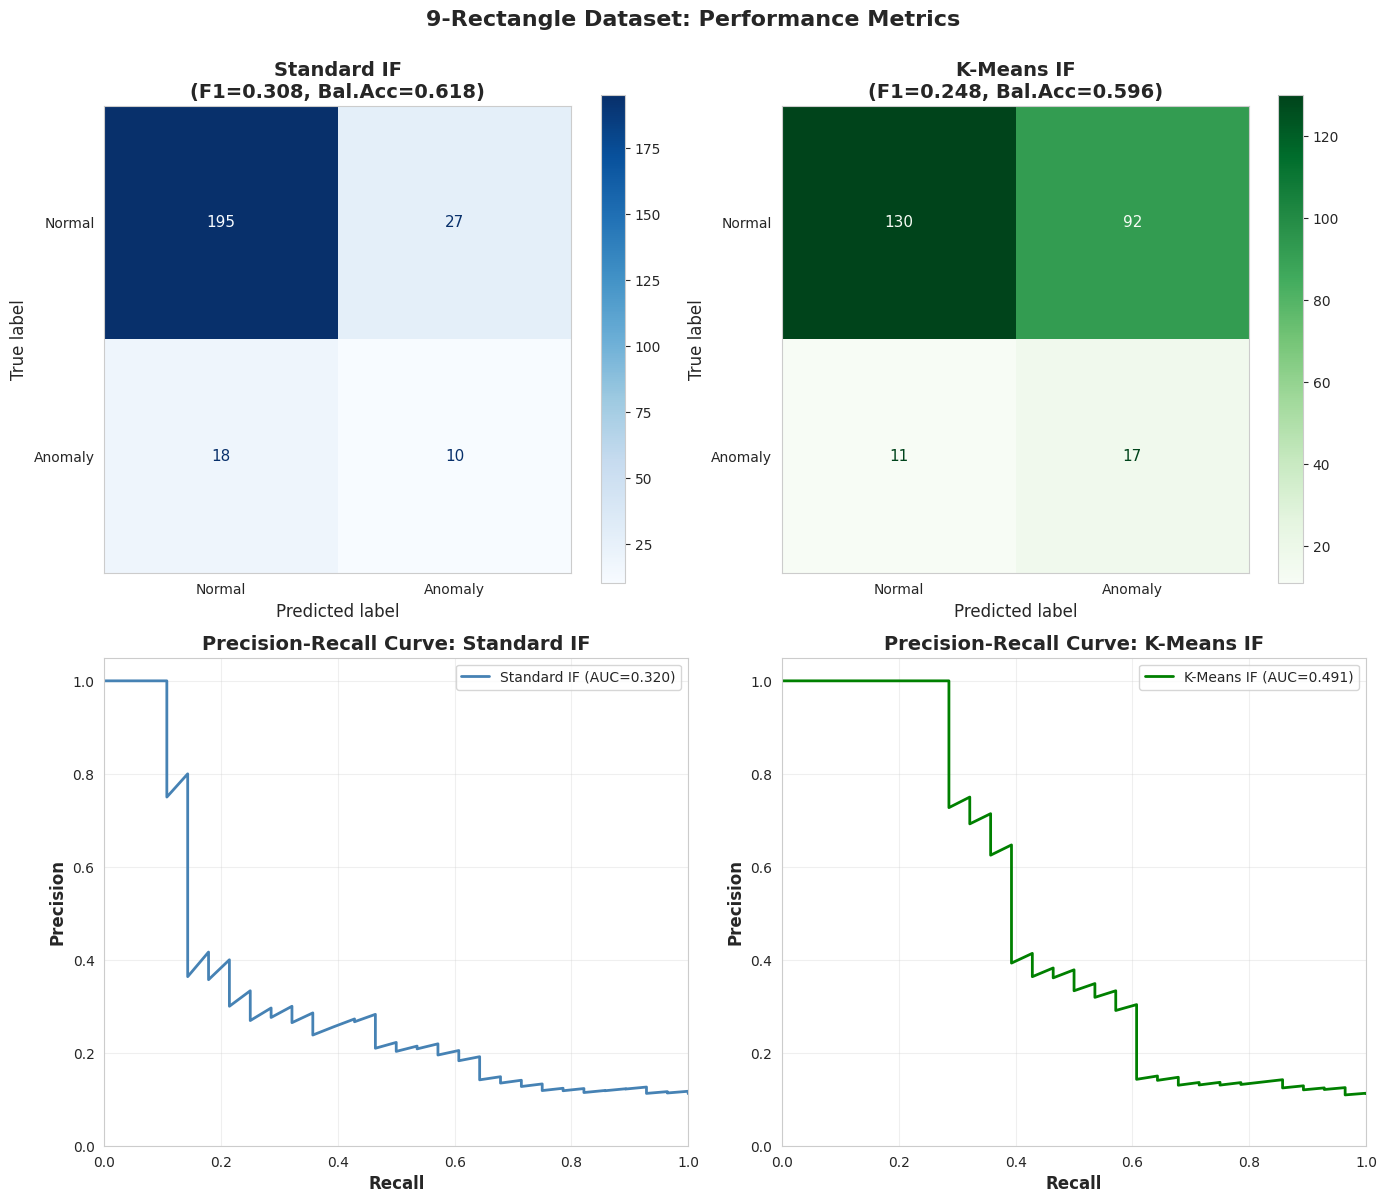

Performance metrics visualization saved ✅

Standard IF  - F1: 0.308, Bal.Acc: 0.618, AUC: 0.320
K-Means IF   - F1: 0.248, Bal.Acc: 0.596, AUC: 0.491


In [28]:
cm_km = confusion_matrix(y_test_rect, pred_test_km)
cm_std = confusion_matrix(y_test_rect, pred_test_std)

precision_km, recall_km, _ = precision_recall_curve(y_test_rect, scores_test_km)
precision_std, recall_std, _ = precision_recall_curve(y_test_rect, scores_test_std)

auc_km = average_precision_score(y_test_rect, scores_test_km)
auc_std = average_precision_score(y_test_rect, scores_test_std)

f1_km = f1_score(y_test_rect, pred_test_km)
f1_std = f1_score(y_test_rect, pred_test_std)

bal_acc_km = balanced_accuracy_score(y_test_rect, pred_test_km)
bal_acc_std = balanced_accuracy_score(y_test_rect, pred_test_std)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Confusion Matrix - Standard IF
disp_std = ConfusionMatrixDisplay(confusion_matrix=cm_std, display_labels=['Normal', 'Anomaly'])
disp_std.plot(ax=axes[0, 0], cmap='Blues', values_format='d')
axes[0, 0].set_title(f'Standard IF\n(F1={f1_std:.3f}, Bal.Acc={bal_acc_std:.3f})', fontweight='bold')
axes[0, 0].grid(False)

# Confusion Matrix - K-Means IF
disp_km = ConfusionMatrixDisplay(confusion_matrix=cm_km, display_labels=['Normal', 'Anomaly'])
disp_km.plot(ax=axes[0, 1], cmap='Greens', values_format='d')
axes[0, 1].set_title(f'K-Means IF\n(F1={f1_km:.3f}, Bal.Acc={bal_acc_km:.3f})', fontweight='bold')
axes[0, 1].grid(False)

# Precision-Recall Curve - Standard IF
axes[1, 0].plot(recall_std, precision_std, linewidth=2, color='steelblue', label=f'Standard IF (AUC={auc_std:.3f})')
axes[1, 0].set_xlabel('Recall', fontweight='bold')
axes[1, 0].set_ylabel('Precision', fontweight='bold')
axes[1, 0].set_title('Precision-Recall Curve: Standard IF', fontweight='bold')
axes[1, 0].legend(loc='best')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim([0, 1])
axes[1, 0].set_ylim([0, 1.05])

# Precision-Recall Curve - K-Means IF
axes[1, 1].plot(recall_km, precision_km, linewidth=2, color='green', label=f'K-Means IF (AUC={auc_km:.3f})')
axes[1, 1].set_xlabel('Recall', fontweight='bold')
axes[1, 1].set_ylabel('Precision', fontweight='bold')
axes[1, 1].set_title('Precision-Recall Curve: K-Means IF', fontweight='bold')
axes[1, 1].legend(loc='best')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim([0, 1])
axes[1, 1].set_ylim([0, 1.05])

plt.suptitle('9-Rectangle Dataset: Performance Metrics', fontweight='bold', fontsize=16, y=1.00)
plt.tight_layout()
plt.savefig('../results/illustrations/9_rectangles_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("Performance metrics visualization saved \u2705")
print(f"\nStandard IF  - F1: {f1_std:.3f}, Bal.Acc: {bal_acc_std:.3f}, AUC: {auc_std:.3f}")
print(f"K-Means IF   - F1: {f1_km:.3f}, Bal.Acc: {bal_acc_km:.3f}, AUC: {auc_km:.3f}")

### Anomaly Score Heatmaps

Computing anomaly scores for heatmap


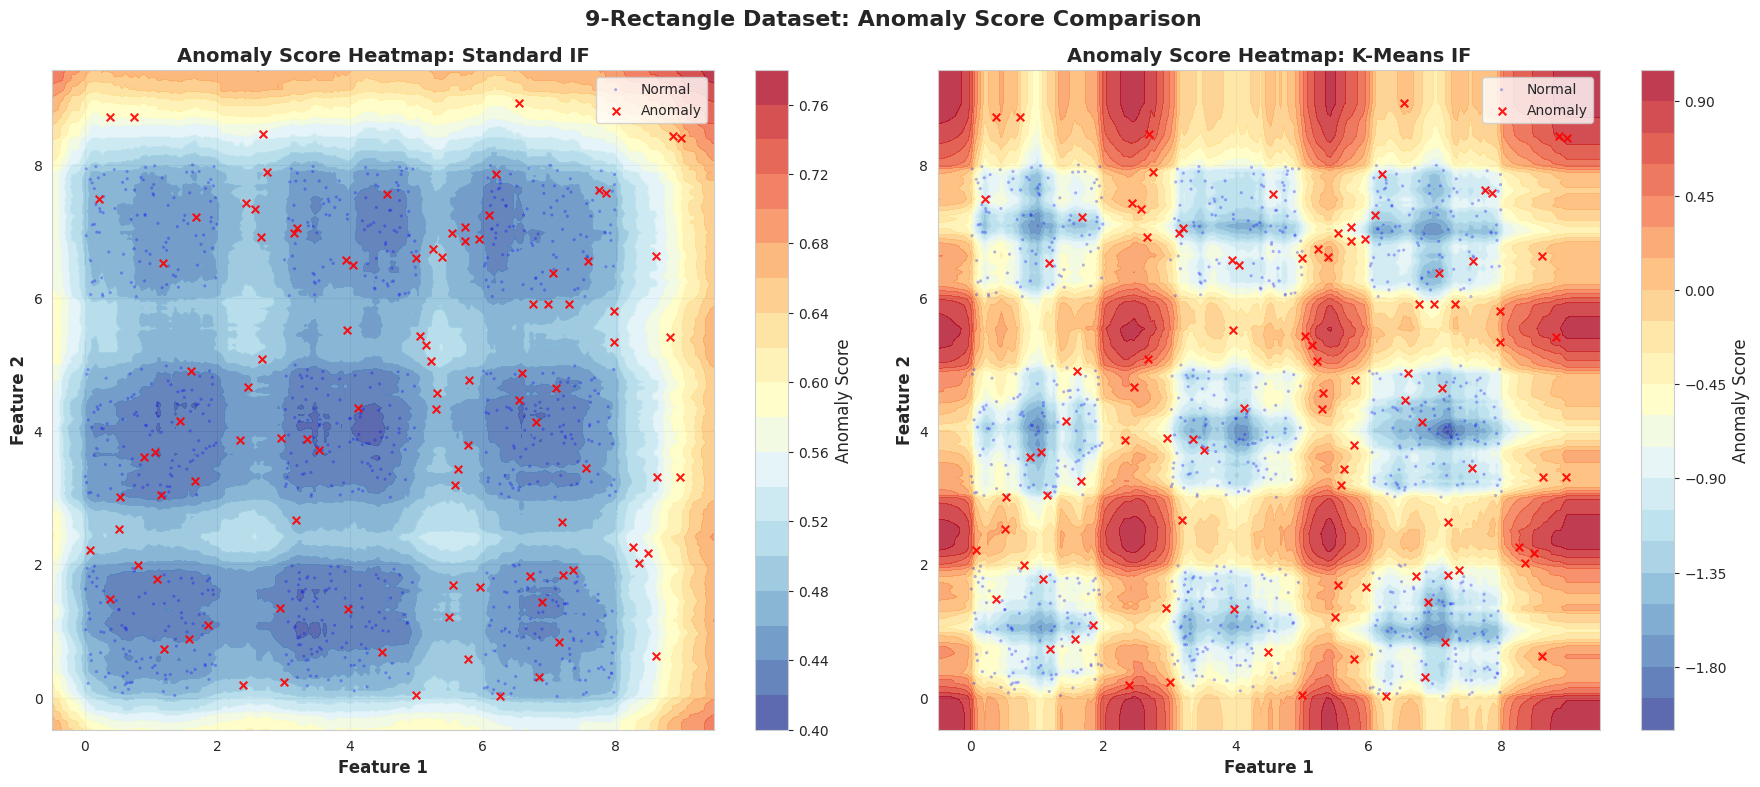

Anomaly score heatmap saved ✅


In [29]:
x_min, x_max = X_rect[:, 0].min() - 0.5, X_rect[:, 0].max() + 0.5
y_min, y_max = X_rect[:, 1].min() - 0.5, X_rect[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Get scores for grid
print("Computing anomaly scores for heatmap")
scores_grid_std = if_standard.scores(grid_points).reshape(xx.shape)
scores_grid_km = if_kmeans.scores(grid_points).reshape(xx.shape)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Standard IF heatmap
im1 = axes[0].contourf(xx, yy, scores_grid_std, levels=20, cmap='RdYlBu_r', alpha=0.8)
axes[0].scatter(X_rect[y_rect == 0, 0], X_rect[y_rect == 0, 1], 
                c='blue', s=5, alpha=0.3, edgecolors='none', label='Normal')
axes[0].scatter(X_rect[y_rect == 1, 0], X_rect[y_rect == 1, 1], 
                c='red', s=30, alpha=0.9, marker='x', linewidths=1.5, label='Anomaly')
axes[0].set_xlabel('Feature 1', fontweight='bold')
axes[0].set_ylabel('Feature 2', fontweight='bold')
axes[0].set_title('Anomaly Score Heatmap: Standard IF', fontweight='bold', fontsize=14)
axes[0].legend(loc='upper right')
plt.colorbar(im1, ax=axes[0], label='Anomaly Score')

# K-Means IF heatmap
im2 = axes[1].contourf(xx, yy, scores_grid_km, levels=20, cmap='RdYlBu_r', alpha=0.8)
axes[1].scatter(X_rect[y_rect == 0, 0], X_rect[y_rect == 0, 1], 
                c='blue', s=5, alpha=0.3, edgecolors='none', label='Normal')
axes[1].scatter(X_rect[y_rect == 1, 0], X_rect[y_rect == 1, 1], 
                c='red', s=30, alpha=0.9, marker='x', linewidths=1.5, label='Anomaly')
axes[1].set_xlabel('Feature 1', fontweight='bold')
axes[1].set_ylabel('Feature 2', fontweight='bold')
axes[1].set_title('Anomaly Score Heatmap: K-Means IF', fontweight='bold', fontsize=14)
axes[1].legend(loc='upper right')
plt.colorbar(im2, ax=axes[1], label='Anomaly Score')

plt.suptitle('9-Rectangle Dataset: Anomaly Score Comparison', fontweight='bold', fontsize=16, y=0.98)
plt.tight_layout()
plt.savefig('../results/illustrations/9_rectangles_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Anomaly score heatmap saved \u2705")

---
# Section 3: Moons Dataset Visualization

Training models on moons dataset...


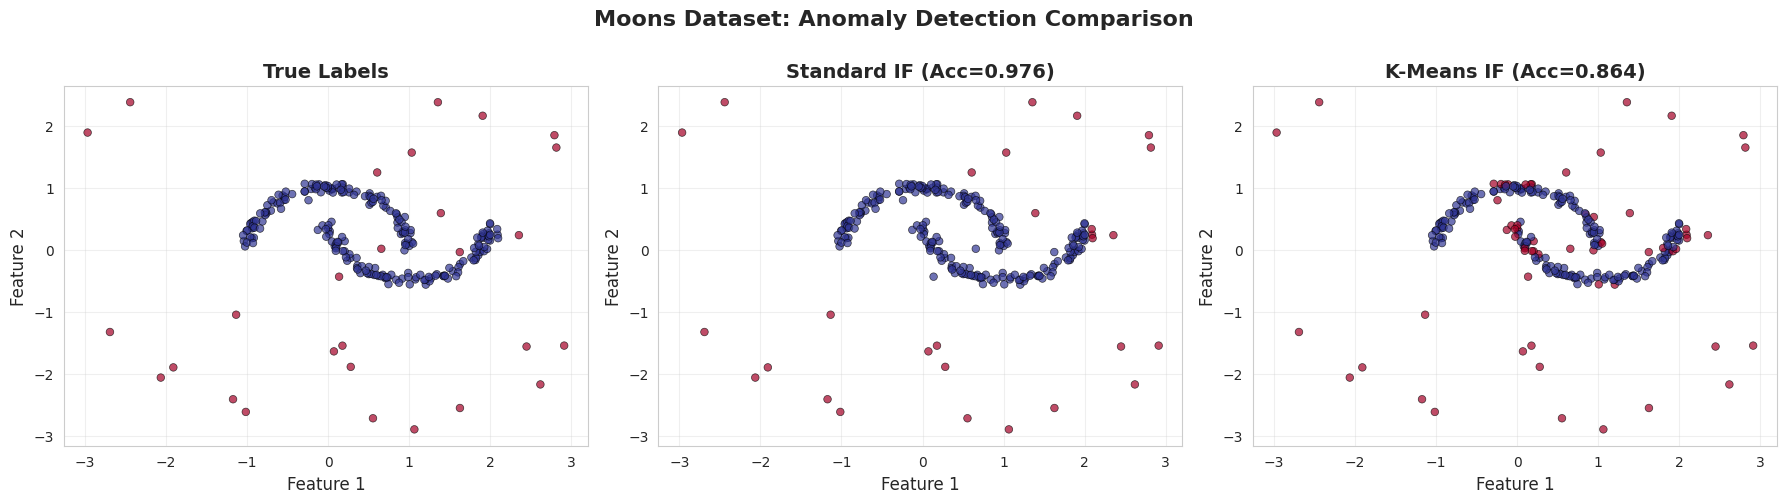

Moons dataset visualization saved ✅
Standard IF accuracy: 0.976
K-Means IF accuracy: 0.864


In [30]:
X_moons, y_moons = generate_moons(n_normal=900, n_anomalies=100, seed=42)
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(
    X_moons, y_moons, test_size=0.25, random_state=42
)

print("Training models on moons dataset...")
if_std_moons = IsolationForest(ensemble_size=100, random_state=42, n_jobs=-1)
if_std_moons.fit(X_train_moons, subsample_size=256, contamination=0.1)

if_km_moons = KMeansIsolationForest(ensemble_size=100, random_state=42, n_jobs=-1)
if_km_moons.fit(X_train_moons, subsample_size=256, contamination=0.1)

# Predictions
pred_test_km_moons = if_km_moons.predict(X_test_moons)
pred_test_std_moons = if_std_moons.predict(X_test_moons)

acc_km_moons = np.mean(pred_test_km_moons == y_test_moons)
acc_std_moons = np.mean(pred_test_std_moons == y_test_moons)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# True labels
axes[0].scatter(X_test_moons[:, 0], X_test_moons[:, 1], c=y_test_moons, 
                cmap='RdYlBu_r', s=30, alpha=0.7, edgecolors='k', linewidths=0.5)
axes[0].set_title('True Labels', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].grid(True, alpha=0.3)

# Standard IF predictions
axes[1].scatter(X_test_moons[:, 0], X_test_moons[:, 1], c=pred_test_std_moons, 
                cmap='RdYlBu_r', s=30, alpha=0.7, edgecolors='k', linewidths=0.5)
axes[1].set_title(f'Standard IF (Acc={acc_std_moons:.3f})', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].grid(True, alpha=0.3)

# K-Means IF predictions
axes[2].scatter(X_test_moons[:, 0], X_test_moons[:, 1], c=pred_test_km_moons, 
                cmap='RdYlBu_r', s=30, alpha=0.7, edgecolors='k', linewidths=0.5)
axes[2].set_title(f'K-Means IF (Acc={acc_km_moons:.3f})', fontweight='bold', fontsize=14)
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Moons Dataset: Anomaly Detection Comparison', fontweight='bold', fontsize=16, y=1.00)
plt.tight_layout()

plt.savefig('../results/illustrations/moons_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Moons dataset visualization saved \u2705")
print(f"Standard IF accuracy: {acc_std_moons:.3f}")
print(f"K-Means IF accuracy: {acc_km_moons:.3f}")

---
# Section 4: Circles Dataset Visualization

Training models on circles dataset...
✓ Done


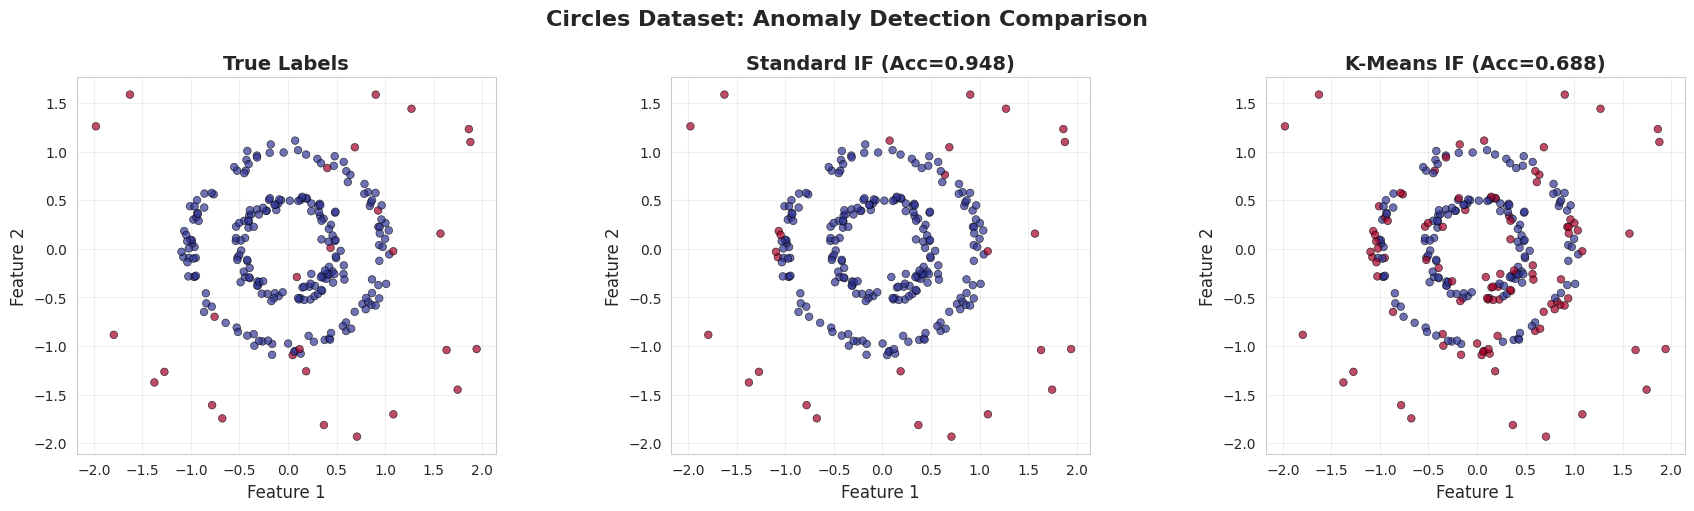

Circles dataset visualization saved ✅
Standard IF accuracy: 0.948
K-Means IF accuracy: 0.688


In [32]:
X_circles, y_circles = generate_circles(n_normal=900, n_anomalies=100, seed=42)
X_train_circles, X_test_circles, y_train_circles, y_test_circles = train_test_split(
    X_circles, y_circles, test_size=0.25, random_state=42
)

# Train models
print("Training models on circles dataset...")
if_std_circles = IsolationForest(ensemble_size=100, random_state=42, n_jobs=-1)
if_std_circles.fit(X_train_circles, subsample_size=256, contamination=0.1)

if_km_circles = KMeansIsolationForest(ensemble_size=100, random_state=42, n_jobs=-1)
if_km_circles.fit(X_train_circles, subsample_size=256, contamination=0.1)
print("✓ Done")

# Predictions
pred_test_std_circles = if_std_circles.predict(X_test_circles)
pred_test_km_circles = if_km_circles.predict(X_test_circles)

acc_std_circles = np.mean(pred_test_std_circles == y_test_circles)
acc_km_circles = np.mean(pred_test_km_circles == y_test_circles)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# True labels
axes[0].scatter(X_test_circles[:, 0], X_test_circles[:, 1], c=y_test_circles, 
                cmap='RdYlBu_r', s=30, alpha=0.7, edgecolors='k', linewidths=0.5)
axes[0].set_title('True Labels', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# Standard IF predictions
axes[1].scatter(X_test_circles[:, 0], X_test_circles[:, 1], c=pred_test_std_circles, 
                cmap='RdYlBu_r', s=30, alpha=0.7, edgecolors='k', linewidths=0.5)
axes[1].set_title(f'Standard IF (Acc={acc_std_circles:.3f})', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

# K-Means IF predictions
axes[2].scatter(X_test_circles[:, 0], X_test_circles[:, 1], c=pred_test_km_circles, 
                cmap='RdYlBu_r', s=30, alpha=0.7, edgecolors='k', linewidths=0.5)
axes[2].set_title(f'K-Means IF (Acc={acc_km_circles:.3f})', fontweight='bold', fontsize=14)
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')
axes[2].grid(True, alpha=0.3)
axes[2].set_aspect('equal')

plt.suptitle('Circles Dataset: Anomaly Detection Comparison', fontweight='bold', fontsize=16, y=1.00)

plt.tight_layout()
plt.savefig('../results/illustrations/circles_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Circles dataset visualization saved \u2705")
print(f"Standard IF accuracy: {acc_std_circles:.3f}")
print(f"K-Means IF accuracy: {acc_km_circles:.3f}")

---
# Section 5: Rank Difference Analysis

Analyzes how much the two algorithms agree on anomaly rankings.

In [33]:
from scipy.stats import spearmanr, kendalltau

# Use 9-rectangle scores
scores_all_std = if_standard.scores(X_rect)
scores_all_km = if_kmeans.scores(X_rect)

# Calculate ranks
ranks_std = np.argsort(np.argsort(scores_all_std))
ranks_km = np.argsort(np.argsort(scores_all_km))
rank_diff = np.abs(ranks_std - ranks_km)

# Calculate correlation
spearman_corr, _ = spearmanr(scores_all_std, scores_all_km)
kendall_corr, _ = kendalltau(scores_all_std, scores_all_km)

print(f"Spearman correlation: {spearman_corr:.3f}")
print(f"Kendall's tau: {kendall_corr:.3f}")
print(f"Mean rank difference: {rank_diff.mean():.2f}")
print(f"Max rank difference: {rank_diff.max()}")

Spearman correlation: 0.531
Kendall's tau: 0.376
Mean rank difference: 215.42
Max rank difference: 784


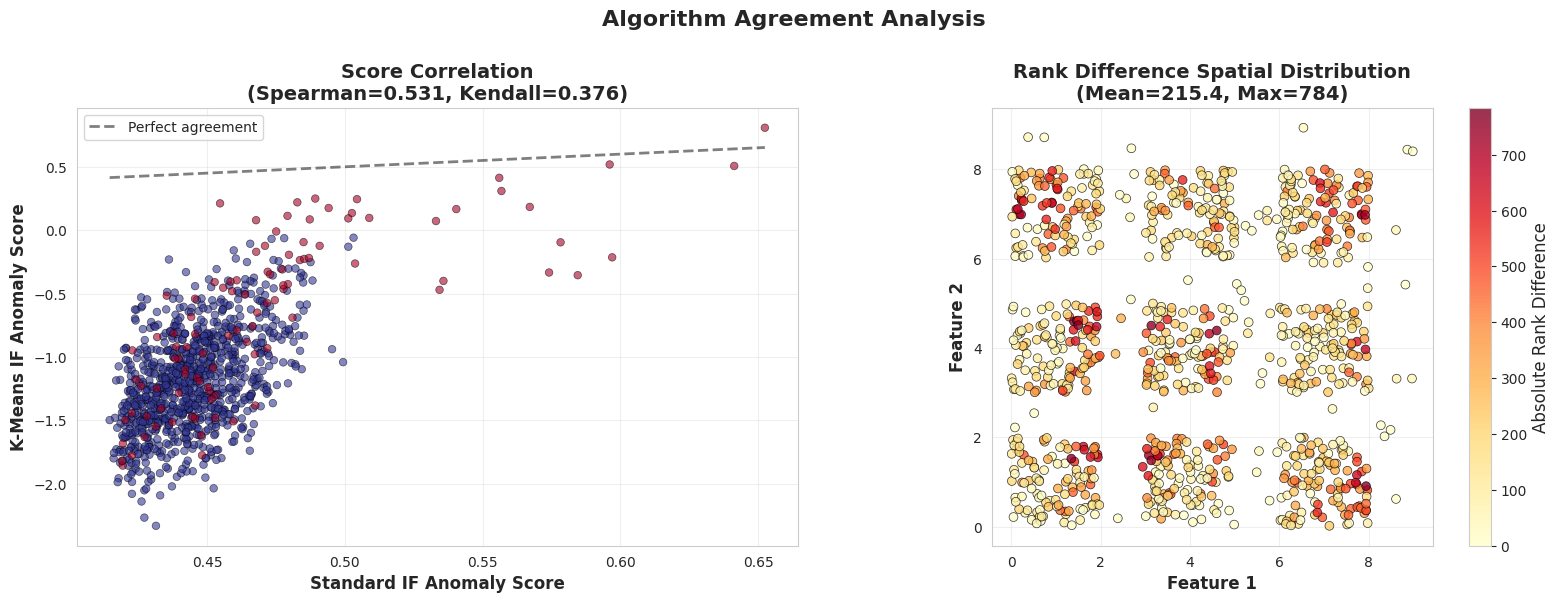

Rank difference analysis saved ✅


In [34]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Score scatter plot
axes[0].scatter(scores_all_std, scores_all_km, c=y_rect, cmap='RdYlBu_r', 
                s=30, alpha=0.6, edgecolors='k', linewidths=0.5)
axes[0].plot([scores_all_std.min(), scores_all_std.max()], 
             [scores_all_std.min(), scores_all_std.max()], 
             'k--', alpha=0.5, linewidth=2, label='Perfect agreement')
axes[0].set_xlabel('Standard IF Anomaly Score', fontweight='bold')
axes[0].set_ylabel('K-Means IF Anomaly Score', fontweight='bold')
axes[0].set_title(f'Score Correlation\n(Spearman={spearman_corr:.3f}, Kendall={kendall_corr:.3f})', 
                  fontweight='bold', fontsize=14)
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Rank difference heatmap
sc = axes[1].scatter(X_rect[:, 0], X_rect[:, 1], c=rank_diff, 
                     cmap='YlOrRd', s=40, alpha=0.8, edgecolors='k', linewidths=0.5)
axes[1].set_xlabel('Feature 1', fontweight='bold')
axes[1].set_ylabel('Feature 2', fontweight='bold')
axes[1].set_title(f'Rank Difference Spatial Distribution\n(Mean={rank_diff.mean():.1f}, Max={rank_diff.max()})', 
                  fontweight='bold', fontsize=14)
plt.colorbar(sc, ax=axes[1], label='Absolute Rank Difference')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

plt.suptitle('Algorithm Agreement Analysis', fontweight='bold', fontsize=16, y=1.00)
plt.tight_layout()
plt.savefig('../results/illustrations/rank_difference_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Rank difference analysis saved \u2705")

---
# Section 6: Score Distribution Comparison

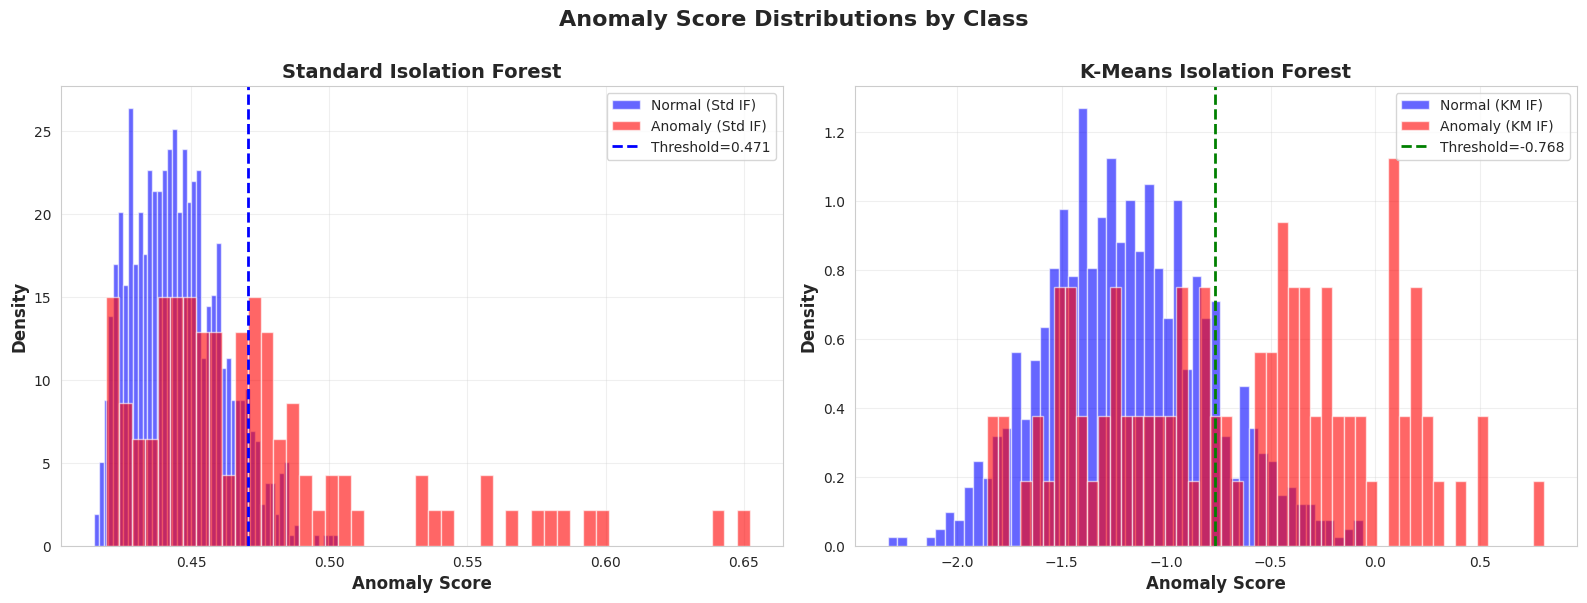

Score distributions visualization saved ✅


In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Score distributions by class
axes[0].hist(scores_all_std[y_rect == 0], bins=50, alpha=0.6, color='blue', 
             label='Normal (Std IF)', density=True)
axes[0].hist(scores_all_std[y_rect == 1], bins=50, alpha=0.6, color='red', 
             label='Anomaly (Std IF)', density=True)
axes[0].axvline(if_standard.anomaly_threshold, color='blue', linestyle='--', 
                linewidth=2, label=f'Threshold={if_standard.anomaly_threshold:.3f}')
axes[0].set_xlabel('Anomaly Score', fontweight='bold')
axes[0].set_ylabel('Density', fontweight='bold')
axes[0].set_title('Standard Isolation Forest', fontweight='bold', fontsize=14)
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

axes[1].hist(scores_all_km[y_rect == 0], bins=50, alpha=0.6, color='blue', 
             label='Normal (KM IF)', density=True)
axes[1].hist(scores_all_km[y_rect == 1], bins=50, alpha=0.6, color='red', 
             label='Anomaly (KM IF)', density=True)
axes[1].axvline(if_kmeans.anomaly_threshold, color='green', linestyle='--', 
                linewidth=2, label=f'Threshold={if_kmeans.anomaly_threshold:.3f}')
axes[1].set_xlabel('Anomaly Score', fontweight='bold')
axes[1].set_ylabel('Density', fontweight='bold')
axes[1].set_title('K-Means Isolation Forest', fontweight='bold', fontsize=14)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Anomaly Score Distributions by Class', fontweight='bold', fontsize=16, y=1.00)
plt.tight_layout()
plt.savefig('../results/illustrations/score_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Score distributions visualization saved \u2705")